최근 전력사용량의 증가로 인해 블랙아웃, 환경 문제 등의 이슈가 대두되면서 전력사용량에 대한 이해와 예측은 중요한 과제로 자리잡았습니다.


기상청에서 발표한 빅데이터 분석보고서에 따르면 전력사용량은 다양한 기상요소들의 영향을 받는다고 합니다. 
특히 전력사용량 예측에 기온 자료 뿐 아니라 습도, 운량, 체감온도, 풍속, 강수량 등의 기상요소를 추가하였을 때 예측 오차를 무려 25% 정도 개선할 수 있어, 비용 절감면에서도 큰 효과를 볼 수 있었습니다.

기상 요소 외에도 건물의 용도, 건물 자재, 건물 면적, 주변 건물과의 거리 등의 변수가 전력사용량에 영향을 미칠 것으로 예상되지만, 저희는 대회에서 주어진 기후 변수, 건물 변수, 시간 변수만을 활용하여 60개의 건물에 대해 전력사용량을 분석 및 예측을 진행하였습니다.


**우선 필요한 변수를 생성하고 결측치를 채우는 전처리를 진행하고, 건물별 전력사용량에 대한 분석과 이를 바탕으로 유사한 건물들로 군집화를 하여 이들의 패턴을 확인하였습니다. 마지막으로 LSTM을 활용하여 건물별로 전력사용량을 예측하였습니다.**



In [ ]:
import pandas as pd
import numpy as np
import math

#Visualizing
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'; plt.rcParams['axes.unicode_minus'] = False;
import seaborn as sns; #sns.set_style('whitegrid')

#Time Series Analysis
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Clustering (+α)
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from minisom import MiniSom

#Modeling
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout

#System
from ipywidgets import interact
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Custom Loss Function
import keras.backend as K

def SMAPE(true,predicted):
    epsilon = 0.1
    summ = K.maximum(K.abs(true) + K.abs(predicted) + epsilon, 0.5 + epsilon)
    smape = K.abs(predicted - true) / summ * 2.0
    return smape

In [ ]:
train = pd.read_csv('train.csv', encoding='euc-kr', parse_dates=['date_time'])
test = pd.read_csv('test.csv', encoding='euc-kr', parse_dates=['date_time'])
submission = pd.read_csv('sample_submission.csv', encoding='euc-kr')

# 전처리

## 시간 관련 변수 생성

먼저 train 데이터와 test 데이터에 월, 일, 시간, 요일, 주말여부에 해당하는 시간 변수를 생성하였습니다.

In [ ]:
#요일
def weekday(x):
    if x.dayofweek == 6:
        return '일'
    elif x.dayofweek == 0:
        return '월'
    elif x.dayofweek == 1:
        return '화'
    elif x.dayofweek == 2:
        return '수'
    elif x.dayofweek == 3:
        return '목'
    elif x.dayofweek == 4:
        return '금'
    else:
        return '토'

# 주말 여부
def weekend(x):
    if x.dayofweek in [5, 6]:
        return 1
    else: 
        return 0

In [ ]:
train['month'] = train['date_time'].dt.month
train['day'] = train['date_time'].dt.day
train['hour'] = train['date_time'].dt.hour
train['weekday'] = train['date_time'].apply(weekday)
train['weekend'] = train['date_time'].apply(weekend)

test['month'] = test['date_time'].dt.month
test['day'] = test['date_time'].dt.day
test['hour'] = test['date_time'].dt.hour
test['weekday'] = test['date_time'].apply(weekday)
test['weekend'] = test['date_time'].apply(weekend)

## test 결측치 채우기

In [ ]:
print('\033[1m<test함수 변수별 결측값 수> \033[0m\n', test.isna().sum())

<test함수 변수별 결측값 수> 
 num                0
date_time          0
기온(°C)          6720
풍속(m/s)         6720
습도(%)           6720
강수량(mm, 6시간)    8400
일조(hr, 3시간)     6720
비전기냉방설비운영       7784
태양광보유           8456
month              0
day                0
hour               0
weekday            0
weekend            0
dtype: int64


데이터를 확인하면 train 데이터에는 결측치가 없지만, test 데이터에는 결측치가 존재함을 알 수 있습니다. 변수별로 조금씩 다른 조금씩 다른 결측치 패턴을 가지는데, 변수의 특성에 따라 다른 방법으로 결측치를 채워주도록 하겠습니다.

**test 데이터 중 결측치 있는 변수:**
- 비전기냉방설비운영, 태양광보유: 불규칙적으로 결측값 있음. 
- 기온(°C),풍속(m/s), 습도(%), 일조(hr, 3시간): 3시간 단위로만 값이 있음 (0,3,6,9,12,15,18,21)
- 강수량(mm, 6시간): 6시간 단위로만 값이 있음 (0,6,12,18)

### 결측치 채우기: 건물 변수 

먼저 건물 변수인 '비전기냉방설비운영','태양광보유'의 결측치를 채워주겠습니다. 건물정보는 건물이 동일하면 모든 같은 값을 가지고, test 데이터의 건물 종류는 train 데이터의 건물 종류와 동일하므로, train 데이터의 건물 변수 값을 이용하여 결측값을 채워주겠습니다.

In [ ]:
building_info = train[['num','비전기냉방설비운영', '태양광보유']].drop_duplicates()

test.drop(columns=['비전기냉방설비운영', '태양광보유'], inplace = True)
test = pd.merge(test, building_info, on= 'num')

### 결측치 채우기: 일조

train 데이터의 일조를 확인하면 discrete한 분포를 지님을 확인할 수 있습니다. 따라서 가장 최근에 기록된 일조값을 가져오는 형태로 결측치를 채워주겠습니다.

In [ ]:
train['일조(hr)'].value_counts()

0.0    85394
1.0    15137
0.1     3376
0.9     3361
0.8     2385
0.7     2306
0.2     2228
0.3     2216
0.6     2083
0.4     2024
0.5     1890
Name: 일조(hr), dtype: int64

In [ ]:
test['일조(hr, 3시간)'] = test['일조(hr, 3시간)'].interpolate(method='pad')

### 결측치 채우기: 기온, 풍속, 습도, 강수량 

기온, 풍속, 습도, 강수량은 'pad','linear','quadratic','cubic' 방법 중 train 데이터에서 가장 성능이 뛰어난 보간법으로 결측치를 채워주겠습니다.

우선 train 데이터에 임의로 결측치를 생성하도록 하겠습니다.

In [ ]:
train_ = train.copy()

In [ ]:
def make_train_nan(col, n):
    new_list = []
    for idx, temp in enumerate(train_[col]):
        if idx%n==0:
            new_list.append(temp)
        else:
            new_list.append(np.nan)
    train_['{}'.format(col+'_nan')] = new_list

In [ ]:
make_train_nan('기온(°C)',3)
make_train_nan('풍속(m/s)',3)
make_train_nan('습도(%)',3)
make_train_nan('강수량(mm)',6)

In [ ]:
print(train_.iloc[:,-4:].isnull().sum())

기온(°C)_nan      81600
풍속(m/s)_nan     81600
습도(%)_nan       81600
강수량(mm)_nan    102000
dtype: int64


결측치가 잘 생성됨을 확인할 수 있습니다.

각 변수에 대해 4가지의 보간법을 시행한 후 가장 오차가 적은 보간법으로 결측치를 채워주겠습니다.

In [ ]:
def compare_interpolate_methods(col, methods, metric):
    error_dict = dict()
    for method in methods:
        fillna = train_['{}'.format(col+'_nan')].interpolate(method=method)
        if fillna.isna().sum() != 0:
            fillna = fillna.interpolate(method='linear')
        error = metric(train_['{}'.format(col)], fillna)
        error_dict['{}'.format(method)] = error
    
    return error_dict

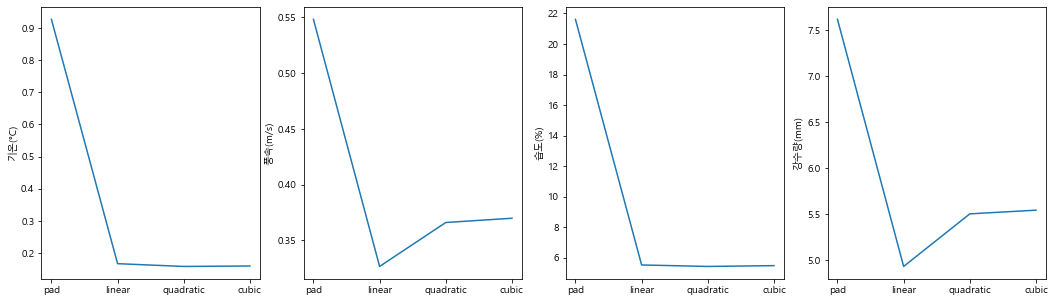

In [ ]:
all_cols_error_dict = dict()
for col in ['기온(°C)', '풍속(m/s)', '습도(%)', '강수량(mm)']:
    methods = ['pad','linear','quadratic','cubic']
    error_dict = compare_interpolate_methods(col, methods, mean_squared_error)
    all_cols_error_dict['{}'.format(col)] = error_dict
    
all_cols_error_df = pd.DataFrame(all_cols_error_dict)

fig, axes = plt.subplots(1,4, figsize = (18,5), sharey=False)
for i in range(len(all_cols_error_df.columns)):
    sns.lineplot(ax=axes[i], data=all_cols_error_df.iloc[:,i].transpose())

In [ ]:
#기온 결측치 채우기
test['기온(°C)'] = test['기온(°C)'].interpolate(method='quadratic')
#마지막 na 채우기
test['기온(°C)'] = test['기온(°C)'].interpolate(method='linear')

#풍속 결측치 채우기
test['풍속(m/s)'] = test['풍속(m/s)'].interpolate(method='linear')

#습도 결측치 채우기
test['습도(%)'] = test['습도(%)'].interpolate(method='quadratic')
#마지막 na 채우기
test['습도(%)'] = test['습도(%)'].interpolate(method='linear')

#강수량 결측치 채우기
test['강수량(mm, 6시간)'] = test['강수량(mm, 6시간)'].interpolate(method='linear')

## 불쾌지수 생성

마지막으로 날씨 변수를 이용하여 쾌적함의 척도로써 여름철 에어컨 사용 등 전력사용량에 영향을 미칠 것으로 예상되는 불쾌지수를 추가해주겠습니다.

In [ ]:
train['불쾌지수'] = 1.8*train['기온(°C)'] - 0.55*(1-(train['습도(%)']/100))*(1.8*train['기온(°C)']-26) + 32
test['불쾌지수'] = 1.8*test['기온(°C)'] - 0.55*(1-(test['습도(%)']/100))*(1.8*test['기온(°C)']-26) + 32

# (데이터프레임 변수 순서 정리)
train = train[['num','date_time','month', 'day', 'hour','weekday','weekend','기온(°C)','습도(%)','불쾌지수','풍속(m/s)','강수량(mm)','일조(hr)','비전기냉방설비운영','태양광보유','전력사용량(kWh)']]
test = test[['num','date_time','month', 'day', 'hour','weekday','weekend','기온(°C)','습도(%)','불쾌지수','풍속(m/s)','강수량(mm, 6시간)','일조(hr, 3시간)','비전기냉방설비운영','태양광보유']]

# Exploratory Data Analysis

## 전력사용량 기본 EDA

### 건물들의 평균 전력사용량

<AxesSubplot:xlabel='전력사용량(kWh)', ylabel='Count'>

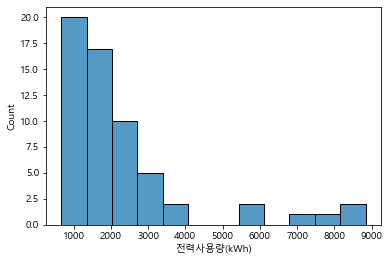

In [ ]:
sns.histplot(train.groupby('num')['전력사용량(kWh)'].mean())

한 시간에 평균 1000kWh를 쓰는 건물부터 9000kWh를 쓰는 건물까지 건물마다 전력사용량의 총량이 매우 다양하다는 것을 확인할 수 있습니다. 

### 건물 변수와 전력사용량의 관계

In [ ]:
train.groupby(['비전기냉방설비운영','태양광보유'])['전력사용량(kWh)'].mean()

비전기냉방설비운영  태양광보유
0.0        0.0      2077.030506
           1.0      1582.298192
1.0        0.0      2101.993590
           1.0      2949.726621
Name: 전력사용량(kWh), dtype: float64

일반적으로 비전기냉방설비를 운영하고 태양광을 보유하면 전력사용량이 더 적을 것으로 예상할 수 있습니다. 건물별 거주인구, 유동인구 및 건물면적 등의 정보를 모르기 때문에 주어진 건물 변수와 전력사용량의 관계를 정확히 알 수는 없지만, 예상과 달리 비전기냉방설비운영 여부, 태양광보유 여부가 건물의 전력사용량을 낮춰주진 않는다는 것을 확인할 수 있습니다.

### 건물별 전력사용량과 다른 변수들의 상관관계

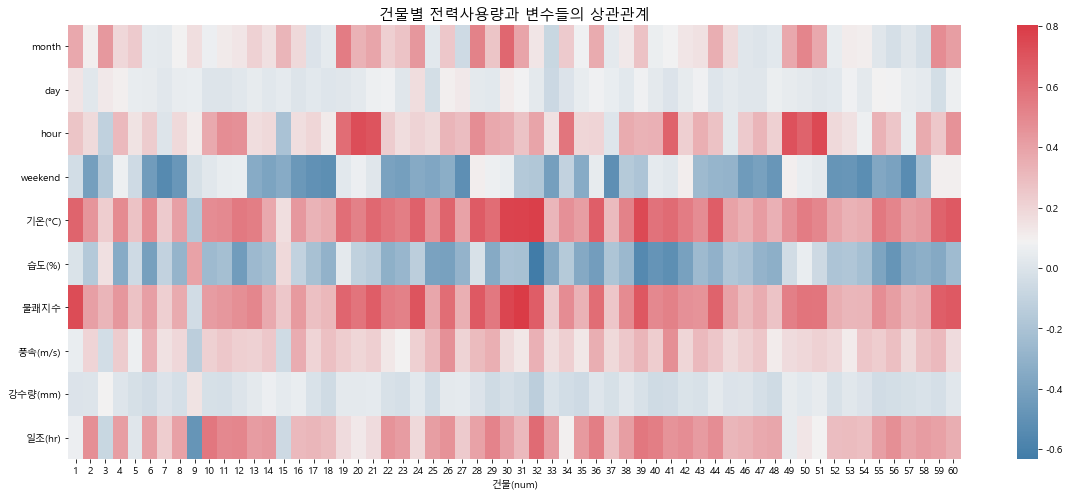

In [ ]:
corr = []
for num in range(1,61):
    df = train[train.num==num]
    num_corr = df.corr()['전력사용량(kWh)']
    num_corr = num_corr.drop(['num','비전기냉방설비운영','태양광보유','전력사용량(kWh)'])
    corr.append(num_corr)
corr_df = pd.concat(corr, axis=1).T
corr_df.index = list(range(1,61))

# 시각화
f, ax = plt.subplots(figsize=(20,8))
plt.title("건물별 전력사용량과 변수들의 상관관계", fontsize=15)
sns.heatmap(corr_df.T, cmap=sns.diverging_palette(240,10,as_cmap=True), ax=ax)
plt.xlabel('건물(num)')
plt.show()

**건물별로 전력사용량과의 각 변수들의 상관계수가 다름을 알 수 있습니다.**

예를 들어,
- 건물1: 기온과 강한 양의 상관관계를 가지고,
- 건물9: 기온과는 상관관계가 거의 없고, 일조와 음의 상관관계를 가집니다.

이후 전력사용량을 모델링할 때 이를 기반으로 건물별로 다른 변수를 사용하도록 하였습니다.


## 시계열 분석

건물별로 시계열 분포가 다르므로 대표로 2개의 건물(건물4, 건물9)에 대해 시계열 분석을 하여 어떤 시계열적 특징이 있는지 확인해보았습니다,

### 시계열 분해

우선 시계열 분해를 통해 건물별 전력사용량을 추세, 계절성, 잔차로 분해하였습니다.

In [ ]:
def vis_time_series_decompose(num):
    df = train[train.num==num]
    df.index = df.date_time

    res = sm.tsa.seasonal_decompose(df['전력사용량(kWh)'], model='additive')

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 12))
    res.observed.plot(ax=ax1, title='Observed')
    res.trend.plot(ax=ax2, title='Trend')
    res.resid.plot(ax=ax3, title='Residual')
    res.seasonal.plot(ax=ax4, title='Seasonal')
    plt.tight_layout()
    plt.show()

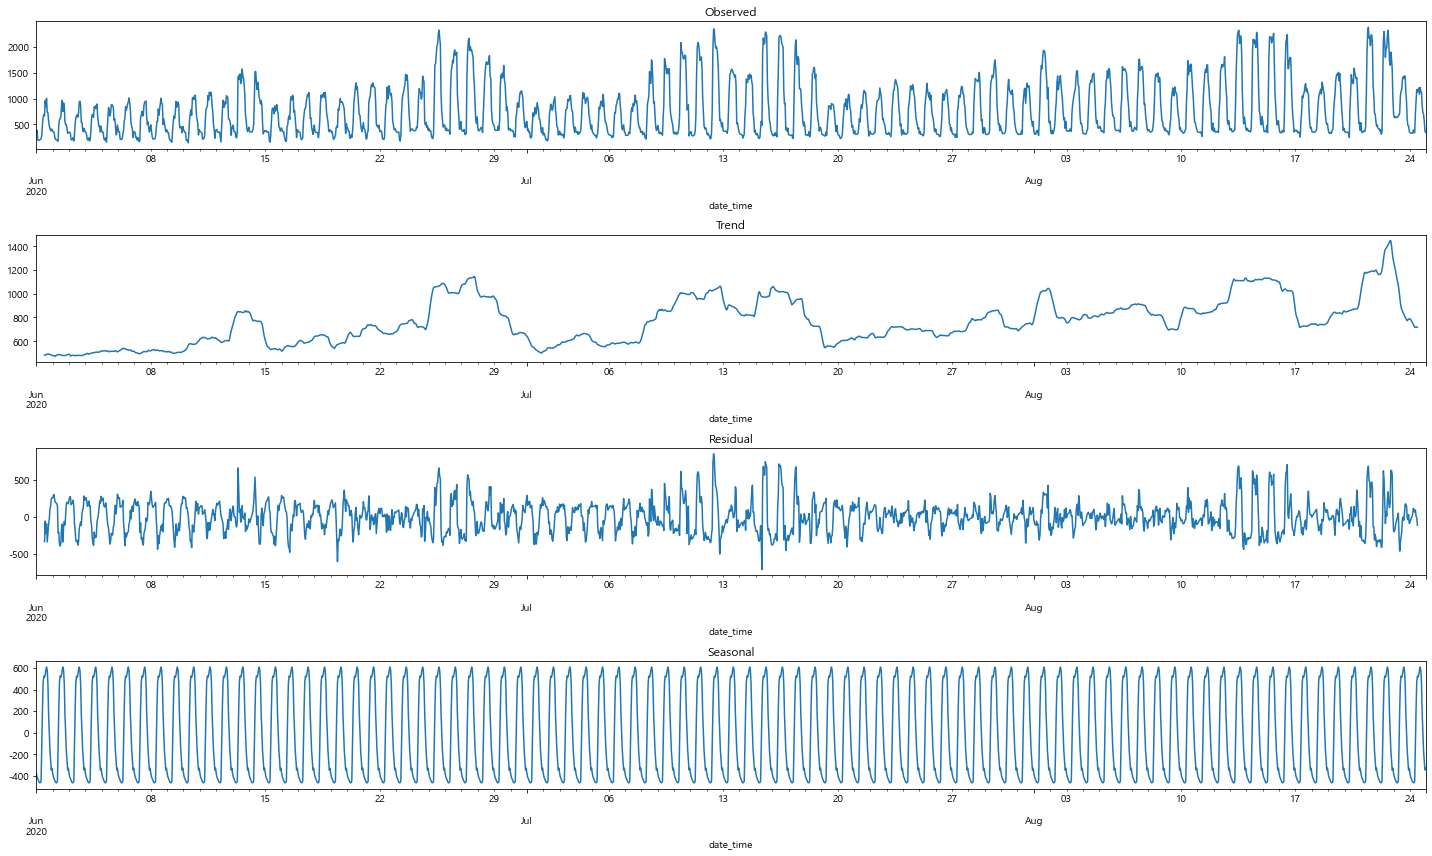

In [ ]:
## 건물4
vis_time_series_decompose(num=4)

건물4의 경우, 하루를 주기로 계절성을 지님을 알 수 있습니다. 또한 85일동안 특별히 증가하거나 감소하는 추세는 보이지 않습니다.

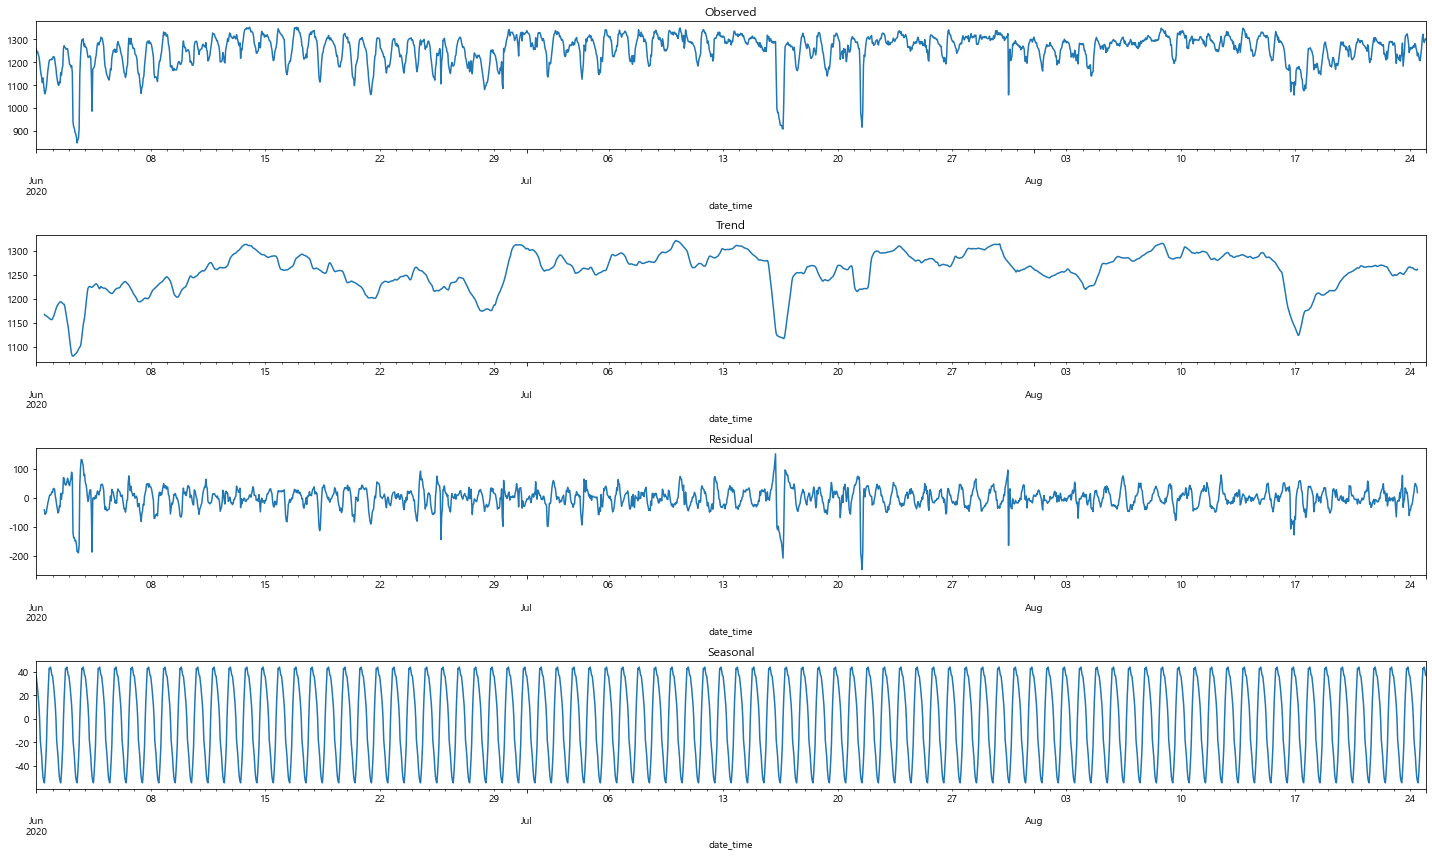

In [ ]:
## 건물9
vis_time_series_decompose(num=9)

건물9의 경우, 마찬가지로 하루를 주기로 계절성을 지님을 알 수 있습니다. 또한 85일동안 특별히 증가하거나 감소하는 추세는 보이지 않습니다.

두 건물 모두 **하루 단위의 계절성이 존재함**으로 하루 단위로 시간에 따른 전력사용량을 관찰할 필요가 있음을 알 수 있습니다. 따라서 아래에 건물별로 시간별 평균 전력사용량에 대한 분석을 진행하였습니다.

### 자기상관 & 부분자기상관

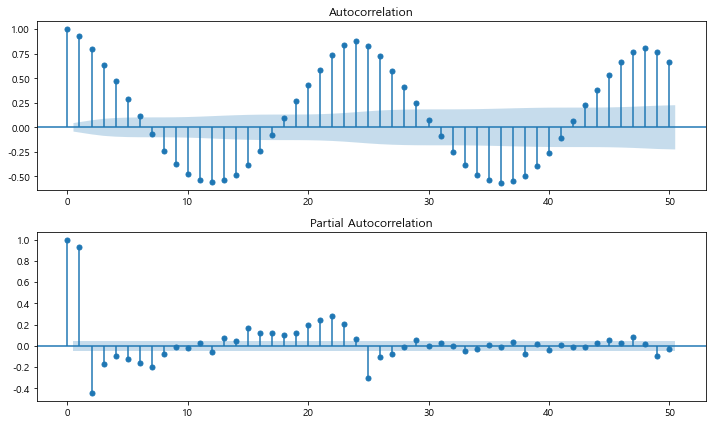

In [ ]:
## 건물4
df = train[train.num==4]
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))
plot_acf(df['전력사용량(kWh)'], lags=50, ax=ax1)
plot_pacf(df['전력사용량(kWh)'], lags=50, ax=ax2)
plt.tight_layout()
plt.show()

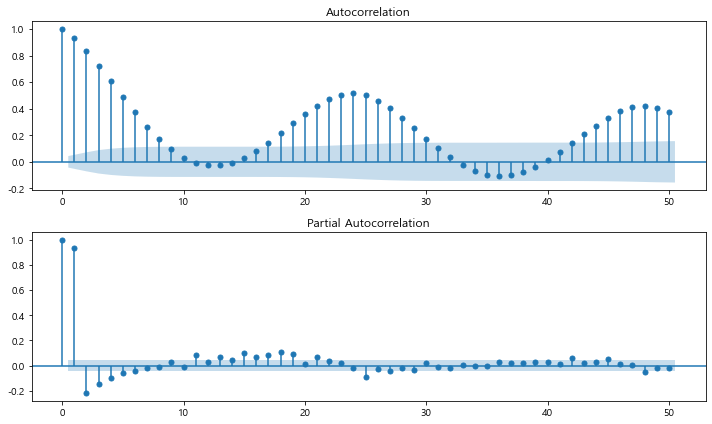

In [ ]:
## 건물9
df = train[train.num==9]
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))
plot_acf(df['전력사용량(kWh)'], lags=50, ax=ax1)
plot_pacf(df['전력사용량(kWh)'], lags=50, ax=ax2)
plt.tight_layout()
plt.show()

PACF를 봤을 때 두 건물 모두 전력사용량은 **1시간, 2시간 전**과 크게 관계가 있고, **약 24시간 전**의 전력사용량에도 약간의 영향을 받음을 확인할 수 있습니다. 따라서 이후 시계열 예측을 진행할 때 직전 시간뿐만 아니라, 24시간 전의 데이터도 활용하여 학습을 하였습니다.

## 각 건물의 시간에 따른 평균 전력사용량 시각화

### 시간별 평균 전력사용량

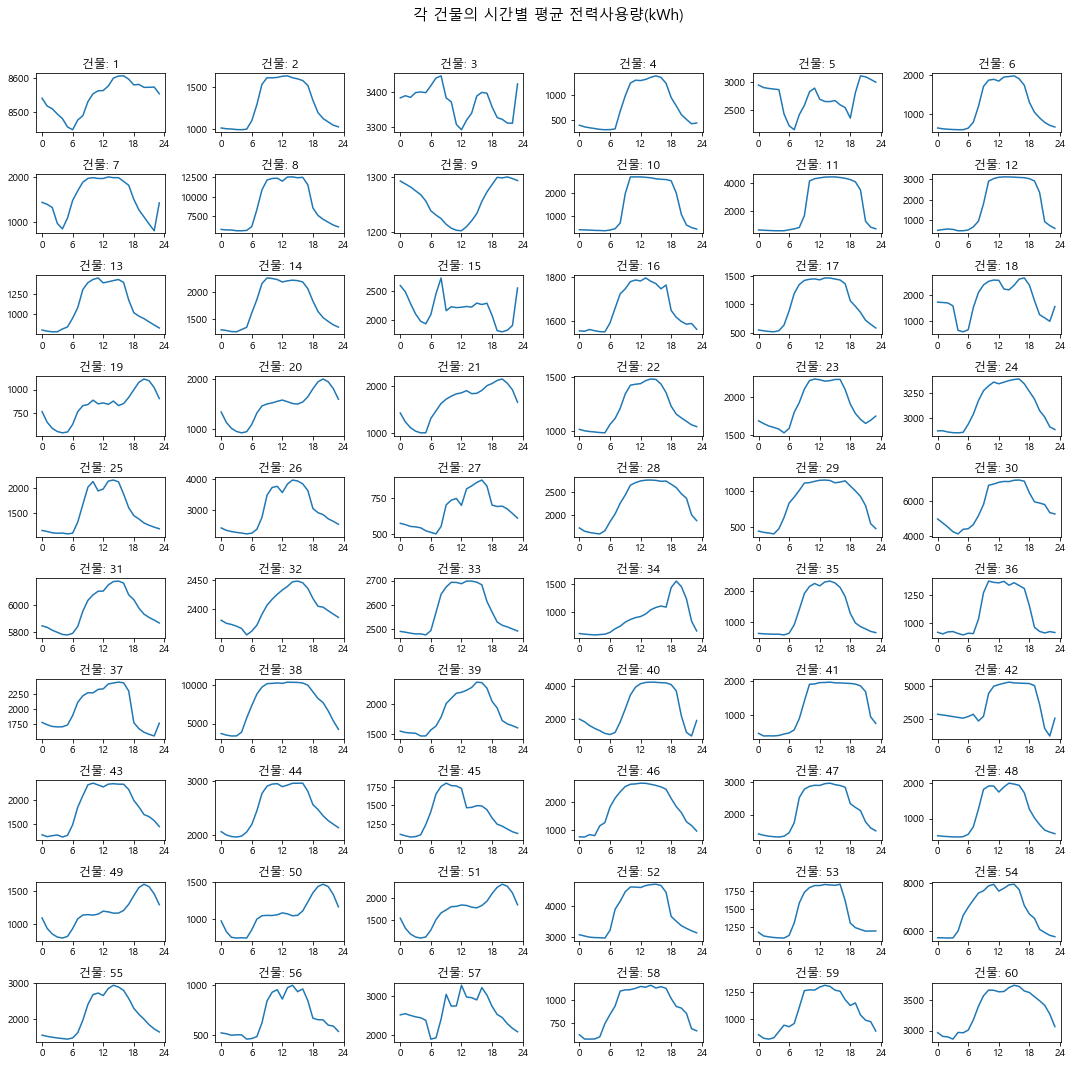

In [ ]:
fig = plt.figure(figsize = (15 ,15))
plt.title("각 건물의 시간별 평균 전력사용량(kWh)", fontsize=15, y=1.05)
plt.axis('off')

for num in range(1,61):
    df = train[train.num==num]
    ax = fig.add_subplot(10,6,num)
    ax.plot(df['hour'].unique(), df.groupby('hour')['전력사용량(kWh)'].mean())
    ax.set_title(f'건물: {num}')
    ax.set_xticks([0,6,12,18,24])
plt.tight_layout()
plt.show()

건물들은 하루동안 시간별로 각각 다르지만 또 비슷한 전력 사용 패턴을 보입니다. 눈에 띄는 패턴에 따라 건물들을 나눠 분석해보았습니다.

1. **6시에 전력사용량이 증가하여 9시~18시까지 전력사용량이 많은 건물**
    - 예시: 2, 4, 6, 8 등
    - 용도 추측: 상가, 사무실이 많은 회사 건물
    
    
2. **1번 패턴과 비슷하나 12시쯤에 전력이 약간 줄어드는 건물**
    - 예시: 6, 8, 13, 14 등
    - 용도 추측: 점심시간을 갖는 회사가 모인 건물
        
        
3. **1번 패턴과 비슷하나 자정쯤에 전력량이 상승하는 건물**
    - 예시: 7, 18, 23, 42 등
    - 용도 추측:새벽에 서버를 돌리는 회사가 있는 건물
    
    
4. **6시부터 상승하여 16시까지 비슷하다가 이후 20시쯤 피크를 찍는 건물**
    - 예시: 19, 20, 21, 49 등
    - 용도 추측: 학원이 많은 건물, 24시간 카페가 있는 건물 
    
    
5. **저녁~새벽에 전력사용량이 많은 건물**
    - 예시: 9 등
    - 용도 추측: 저녁에 영업하는 주점 등이 있는 상가 건물일 가능성 높음

이외에도 건물3의 경우 8시, 16시쯤 피크를 찍는 형태를 보이는 등의 패턴을 보입니다, 

### 요일별 평균 전력사용량

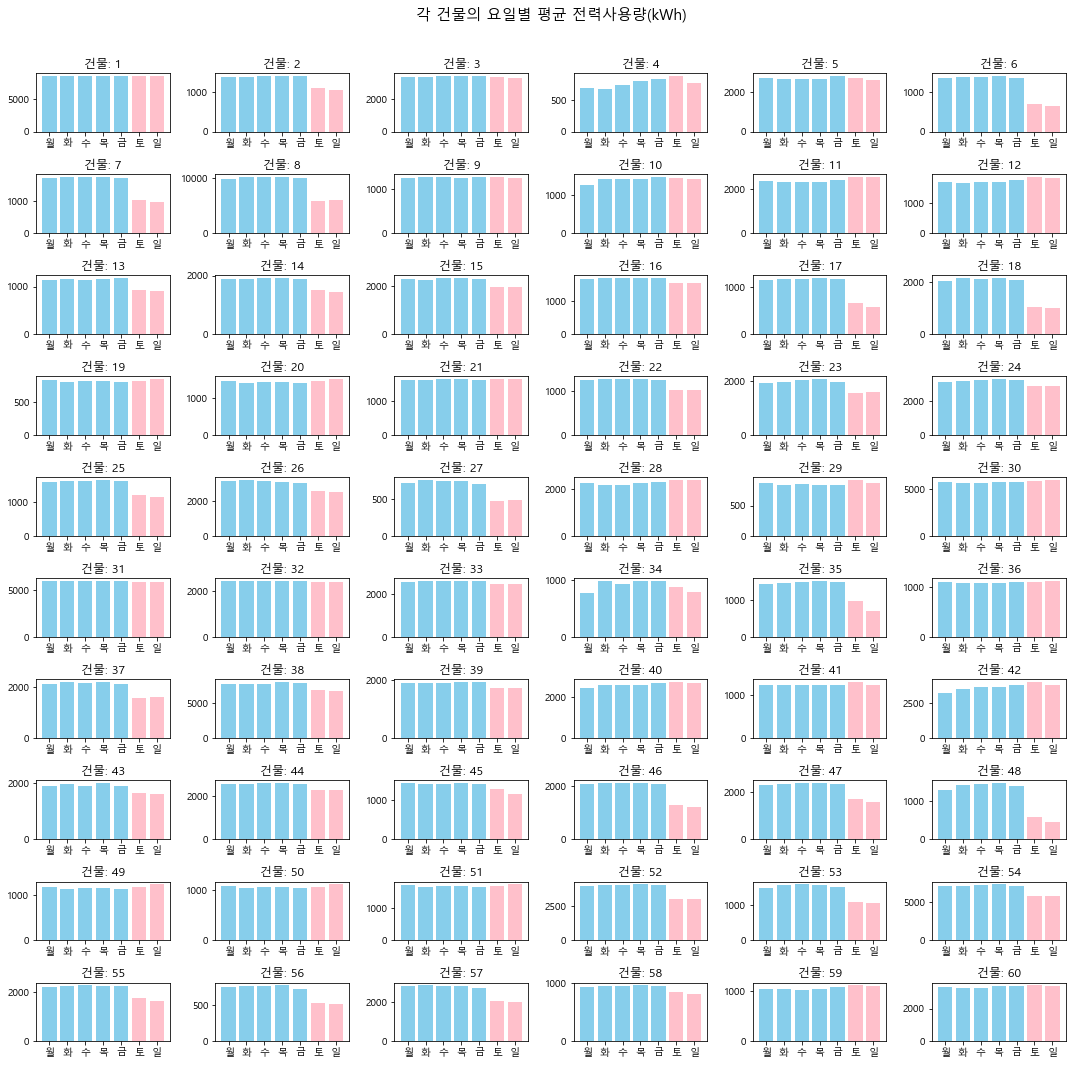

In [ ]:
fig = plt.figure(figsize = (15 ,15))
plt.title("각 건물의 요일별 평균 전력사용량(kWh)", fontsize=15, y=1.05)
plt.axis('off')

weekday = ['월','화','수','목','금','토','일']
colors = ['skyblue','skyblue','skyblue','skyblue','skyblue','pink','pink']

for num in range(1,61):
    df = train[train.num==num]
    df_counts = df.groupby('weekday')['전력사용량(kWh)'].mean()
    df_counts = df_counts.reindex(weekday)
    ax = fig.add_subplot(10,6,num)
    ax.bar(df['weekday'].unique(), df_counts, color=colors)
    ax.set_title(f'건물: {num}')
plt.tight_layout()
plt.show()

일주일동안의 전력사용량을 요일별로 보면 크게 3가지 패턴으로 나뉩니다. 각 패턴에 따라 건물들을 나눠 분석해보았습니다.

1. **주말에 사용량이 감소하는 건물**
    - 예시: 2, 6, 7 등 다수
    - 용도 추측: 사무실이 많은 회사 건물, 학교
    
    
2. **주말에 사용량이 약간 증가하는 건물**
    - 예시: 11, 12 등
    - 용도 추측: 주거용 건물
    
    
3. **요일 상관없이 사용량이 일정한 건물**
    - 예시: 1, 9
    - 용도 추측: 대학병원

### 시간+요일별 평균 전력사용량

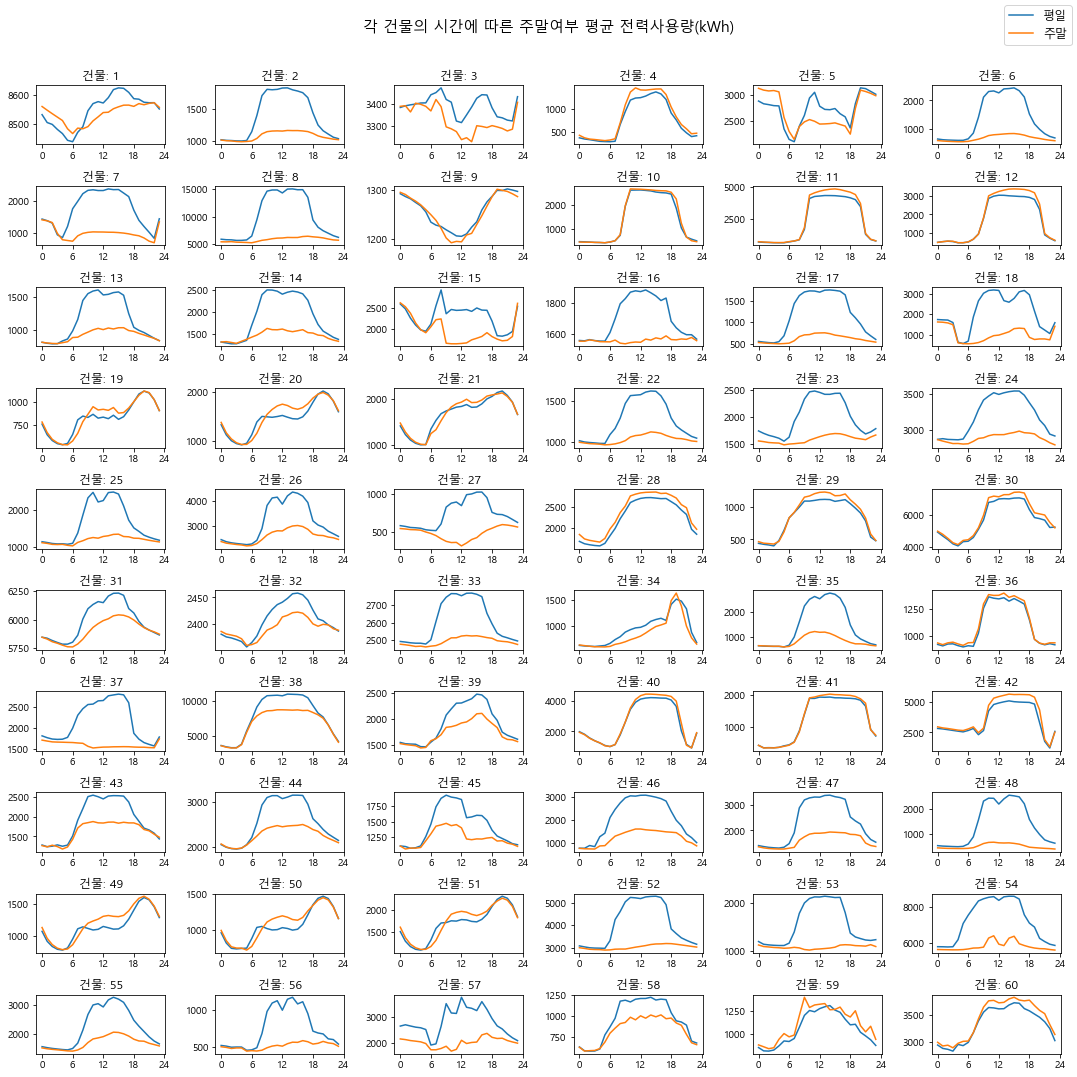

In [ ]:
fig = plt.figure(figsize = (15 ,15))
plt.title("각 건물의 시간에 따른 주말여부 평균 전력사용량(kWh)", fontsize=15, y=1.05)
plt.axis('off')

for num in range(1,61):
    df = train[train.num==num]
    ax = fig.add_subplot(10,6,num)
    ax.plot(df['hour'].unique(), df[df.weekend==0].groupby('hour')['전력사용량(kWh)'].mean(), label='평일')
    ax.plot(df['hour'].unique(), df[df.weekend==1].groupby('hour')['전력사용량(kWh)'].mean(), label='주말')
    ax.set_title(f'건물: {num}')
    ax.set_xticks([0,6,12,18,24])
lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, labels, loc = 1, prop={'size':12})
plt.tight_layout()
plt.show()

마지막으로 평일과 주말을 나눠 하루동안의 전력사용량을 시각화하였습니다. 마찬가지로 패턴에 따라 건물들을 나눠보았습니다.

1. **평일과 주말의 패턴이 비슷한 건물**
    - 예시: 4, 9, 10 등
    

2. **평일과 주말의 낮시간대의 사용량이 차이나는 건물**
    - 예시: 2, 6, 7 등


3. **평일과 주말의 패턴이 반대인 건물**
    - 예시: 27
    
    

건물마다 시간에 따른 패턴이 다르지만 일정한 기준에 의해 묶을 수 있을 것으로 보입니다. 따라서 군집화를 통해 비슷한 패턴을 가진 건물끼리 묶어보도록 하였습니다.

# 군집화

KMeans와 SOM의 두 가지 알고리즘을 사용하여 건물을 군집화하였습니다. 우선 이에 필요한 함수를 생성하였습니다.

In [ ]:
## 시계열 군집화용 DataFrame을 생성하는 함수 (row->num, col->date_time)
def cluster_df(scaler=MinMaxScaler()): # scaler=[False, 'MinMaxScaler()', 'StandardScaler()']
    train_ = train.copy()
    train_ts = train_.pivot_table(values='전력사용량(kWh)', index=train_.num, columns='date_time', aggfunc='first')
    
    if scaler:
        train_ts_T = scaler.fit_transform(train_ts.T)
        train_ts = pd.DataFrame(train_ts_T.T, index=train_ts.index, columns=train_ts.columns)
    
    return train_ts

In [ ]:
## SOM 알고리즘 결과를 정리해주는 DataFrame을 생성하는 함수
def make_som_df(X):
    win_map = som.win_map(X)
    som_result = []
    for i in range(60):
        som_result.append([i+1, som.winner(X[i])])
    som_df = pd.DataFrame(som_result, columns=['num','cluster'])
    return som_df

In [ ]:
## 여러 n_clueter에 대해 TimeSeriesKmeans를 시행하고 이를 시각화하는 함수
def visualize_n_cluster(train_ts, n_lists=[3,4,5,6], metric='dtw', seed=2021, vis=True):

    if vis:
        fig = plt.figure(figsize = (20 ,5))
        plt.title("군집 개수별 건물수 분포", fontsize=15, y=1.2)
        plt.axis('off')
    
    for idx, n in enumerate(n_lists):
        ts_kmeans = TimeSeriesKMeans(n_clusters=n, metric=metric, random_state=seed)
        train_ts['cluster(n={})'.format(n)] = ts_kmeans.fit_predict(train_ts)
        score = round(silhouette_score(train_ts, train_ts['cluster(n={})'.format(n)], metric='euclidean'),3)
        
        vc = train_ts['cluster(n={})'.format(n)].value_counts()
        
        if vis:
            ax = fig.add_subplot(1,len(n_lists), idx+1)
            sns.barplot(x=vc.index, y=vc, palette='Pastel1')
            ax.set(title='n_cluster={0}\nscore: {1}'.format(n,score))
    if vis: 
        plt.tight_layout()
        plt.show()
    
    return train_ts

In [ ]:
## 클러스터 별 시간&요일별 전력사용량 평균 시각화 (new)
def visualize_by_cluster(df_with_labels, n_cluster, algorithm):
    fig = plt.figure(figsize = (20 ,4*n_cluster))
    plt.title('군집 수가 {}개일 때 각 군집별 시계열분포'.format(n_cluster), fontsize=15, y=1.05)
    plt.axis('off')
    
    if algorithm=='kmeans':
        labels = df_with_labels['cluster(n={})'.format(n_cluster)]
    elif algorithm=='som':
        labels = df_with_labels.cluster
    
    idx=1
    for label in set(labels): # 각 군집에 대해
        
        if algorithm=='kmeans':
            df = train[train.num.isin(list(labels[labels==label].keys()))]
        elif algorithm=='som':
            df = train[train.num.isin(som_df[som_df.cluster==label].num.values)]
        
        hour = df.hour.unique()
        weekday = df.weekday.unique()
        
        ### x축: 시간 ###
        ax = fig.add_subplot(n_cluster,2, idx); idx+=1
        ax.set(title='{}번 군집의 시간별 평균 전력사용량'.format(label))
        ax.set_xticks(hour)
        for num in df.num.unique():
            df_one = df[df.num==num]
            sns.lineplot(x=hour, y=df_one.groupby('hour')['전력사용량(kWh)'].mean(), color='grey', alpha=0.3)
        sns.lineplot(x=hour, y=df.groupby('hour')['전력사용량(kWh)'].mean(), color='red')
        
        ### x축: 요일 ###
        ax = fig.add_subplot(n_cluster,2, idx); idx+=1
        ax.set(title='{}번 군집의 요일별 평균 전력사용량'.format(label))
        for num in df.num.unique():
            df_one = df[df.num==num]
            df_one_counts = df_one.groupby('weekday')['전력사용량(kWh)'].mean()
            df_one_counts = df_one_counts.reindex(weekday)
            sns.lineplot(x=weekday, y=df_one_counts, color='grey', alpha=0.3)
        df_counts = df.groupby('weekday')['전력사용량(kWh)'].mean()
        df_counts = df_counts.reindex(weekday)
        sns.pointplot(x=weekday, y=df_counts, color='red')
        ax.legend(['총 {}개 건물'.format(df.num.nunique())], loc=1)

    plt.show()

## Time-Series KMeans

첫 번재로 **Time-Series KMeans 알고리즘**을 이용하여 전력사용량에 따라 건물을 군집화하였습니다. 

이 때, 전력사용량을 **StandardScaler를 이용하여 표준화**하여 건물별 전력의 절대적 사용량이 아닌 사용 패턴을 사용하여 군집화하도록 하였습니다. 

또한 각 관측치간의 거리를 계산할 때는 **euclidean 거리**를 사용하였습니다. 시계열 데이터에서는 시간대가 다르더라도 계산할 수 있다는 장점을 지닌 DTW(Dynamic Time Warping) 거리 계산 방법도 많이 사용하지만, 우리의 데이터는 건물별로 측정 기간이 때문에 속도가 빠른 euclidean 거리 계산 방법을 사용하였습니다. 

군집수의 범위는 위에서 건물별 평균 전력사용량을 시각화하였을 때 크게 3~6개의 패턴을 확인하였으므로 **군집수를 3,4,5,6개로 설정**하여 실루엣계수와 각 군집별 분포를 시각화하였습니다.

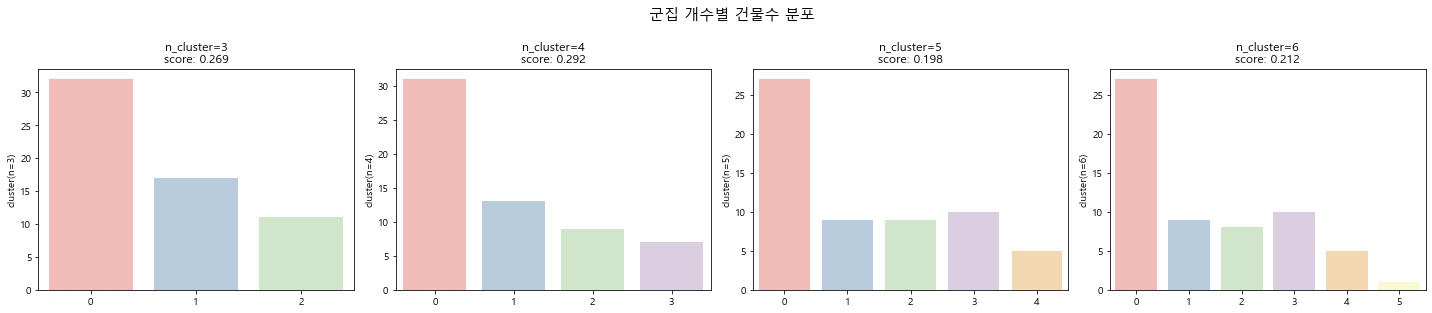

In [ ]:
train_ts = cluster_df(scaler=StandardScaler())
train_ts = visualize_n_cluster(train_ts, n_lists=[3,4,5,6], metric='euclidean', seed=2021, vis=True)

실루엣 계수가 높고 각 군집별로 건물 수가 극단적으로 치우치지 않은 **n_cluster=4**일 때를 선택하여 군집화를 진행하겠습니다.

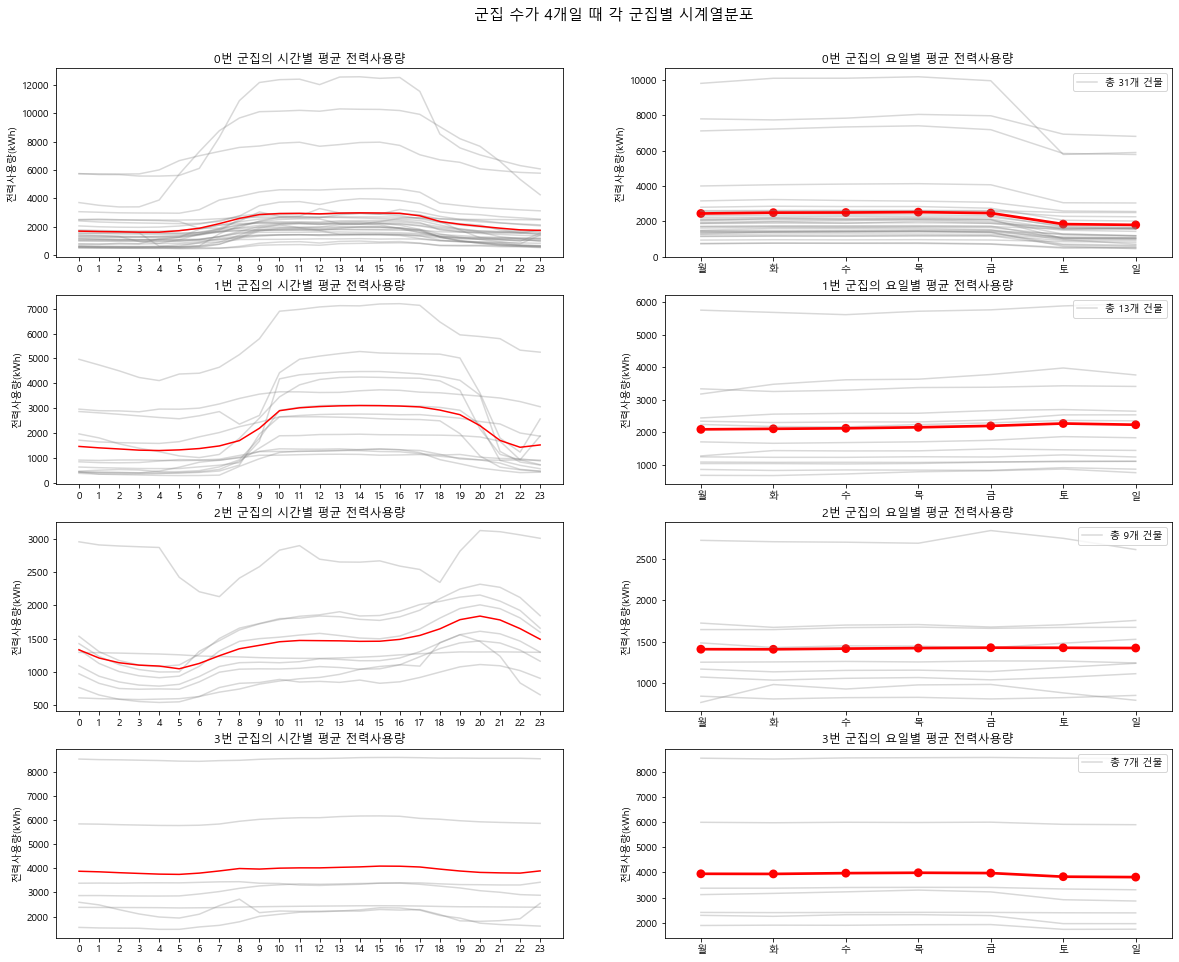

In [ ]:
visualize_by_cluster(train_ts, n_cluster=4, algorithm='kmeans')

각 군집별 내에서 건물들이 비슷한 패턴을 보임을 확인할 수 있습니다. 

- **0번 군집**: 6시~18시까지 전력사용량이 많고, 주말보다 평일의 전력사용량이 많은 건물들
- **1번 군집**: 8시~20시까지 전력사용량이 많고, 주말과 평일의 전력사용량이 비슷한 건물들
- **2번 군집**: 저녁 시간대에 전력사용량이 많고, 주말과 평일의 전력사용량이 비슷한 건물들
- **3번 군집**: 시간별 전력사용량의 차이가 크지 않고, 주말과 평일의 전력사용량이 비슷한 건물들

## SOM(Self-Organizing Maps)

두 번재로 간단한 Neural Net인 **SOM 알고리즘**을 이용하여 전력사용량에 따라 건물을 군집화하였습니다.

마찬가지로 건물별로 전력사용량 표준화를 진행하였고, 2x3의 그리드를 만들어 군집화하였습니다.

In [ ]:
train_ts = cluster_df(scaler=StandardScaler())
X = train_ts.values

som = MiniSom(x=2, y=3, input_len = X.shape[1])
som.random_weights_init(X)
som.train(data=X, num_iteration=50000)

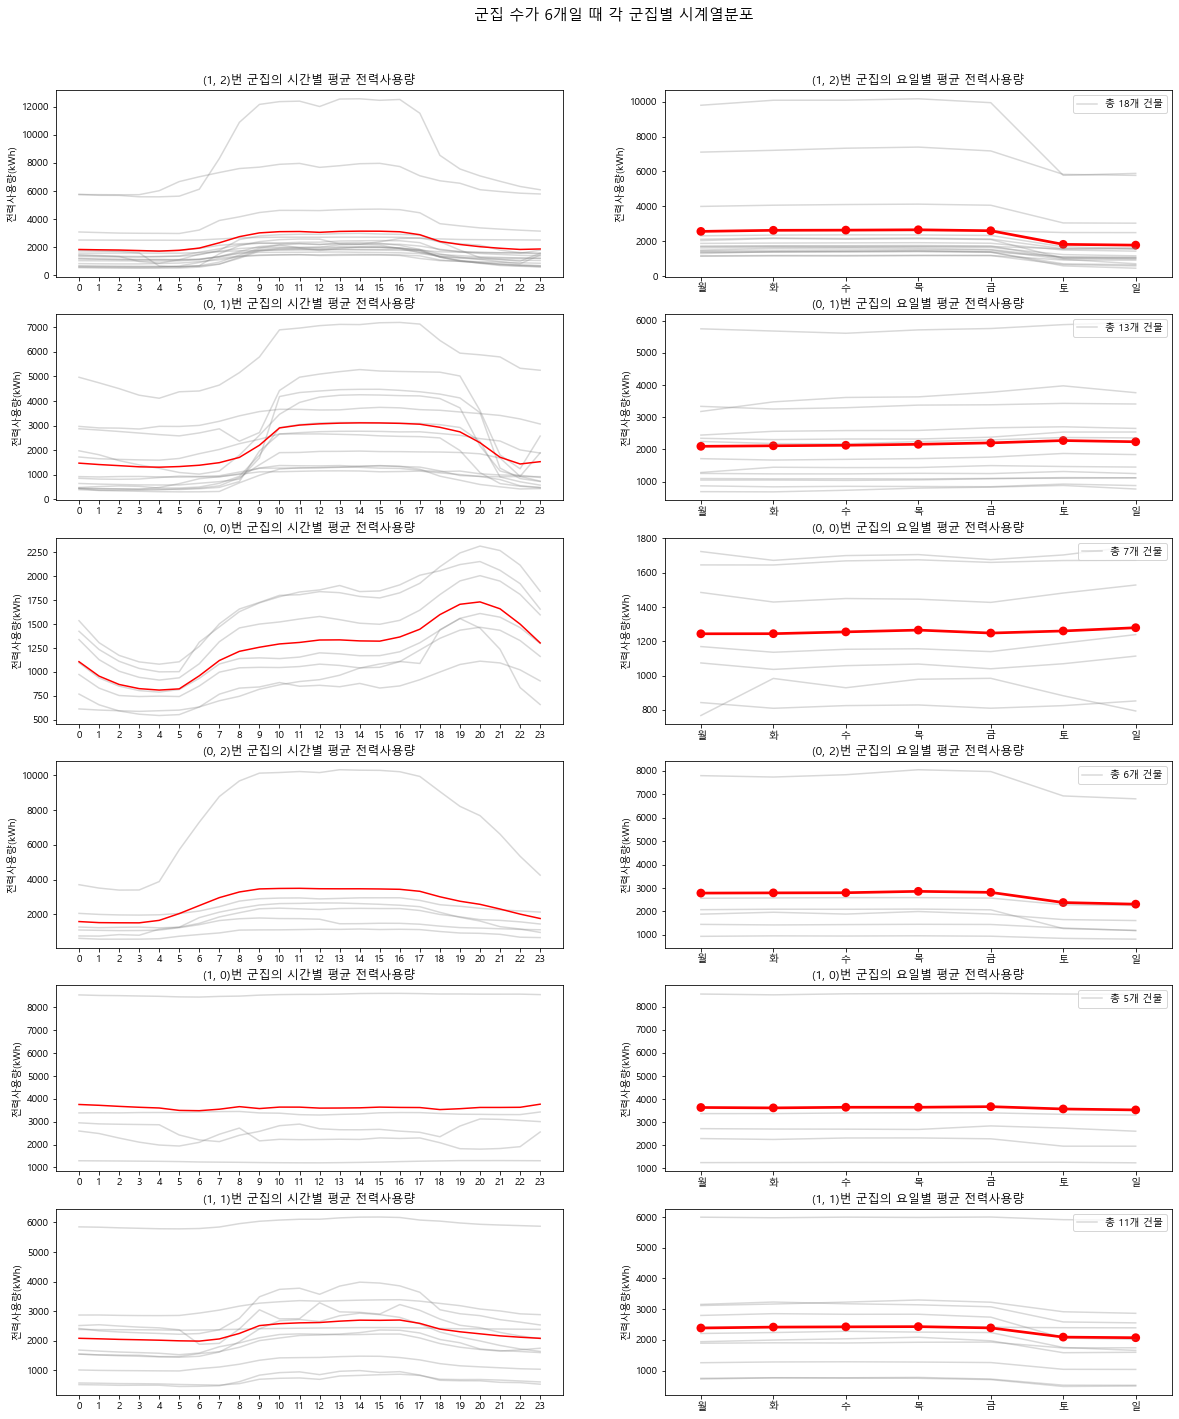

In [ ]:
som_df = make_som_df(X)
visualize_by_cluster(som_df, 6, algorithm='som')

마찬가지로 각 군집별 내에서 건물들이 비슷한 패턴을 보임을 확인할 수 있습니다. 

- **(1,2)번 군집**: 6시~18시까지 전력사용량이 많고, 주말보다 평일의 전력사용량이 많은 건물들
- **(0,1)번 군집**: 8시~20시까지 전력사용량이 많고, 주말과 평일의 전력사용량이 비슷한 건물들
- **(0,0)번 군집**: 저녁 시간대에 전력사용량이 많은 건물들
- **(0,2)번 군집**: 이른 아침부터 저녁까지 전력사용량이 많고, 주말보다 평일의 전력사용량이 많은 건물들
- **(1,0)번 군집**: 시간별 전력사용량의 차이가 크지 않고, 주말과 평일의 전력사용량이 비슷한 건물들
- **(1,1)번 군집**: 8시~20시까지 전력사용량이 많고, 주말보다 평일의 전력사용량이 많은 건물들

대략적으로 위와 같이 각 군집의 특징을 설명할 수 있습니다. 

# 모델링

## LSTM

각 건물별로 전력사용량과의 상관관계가 0.3 이상인 변수를 이용하여 Multivariate Time Series 데이터를 LSTM에 적합하여 학습 및 예측을 진행하였습니다

In [ ]:
# 건물별 모델 및 예측 결과 저장
model_history = {}
forecast_future = {}
predict_past = {}

In [ ]:
for num in tqdm(range(1,61)):
    
    ## 피처 골라내서 데이터프레임 만들기
    train_num1 = train_[train_.num==num]
    train_num1_corr = train_num1.corr()['전력사용량(kWh)']
    variables = train_num1_corr[abs(train_num1_corr)>0.3].keys().tolist()
    train_num1 = train_num1[variables]
    
    ## 정규화
    if train_num1.shape[1]>1:
        feature_scaler = MinMaxScaler()
        train_num1.iloc[:,:-1] = feature_scaler.fit_transform(train_num1.iloc[:,:-1])

    y_scaler = StandardScaler()
    y_scaler.fit(train_num1[['전력사용량(kWh)']])
    train_num1['전력사용량(kWh)'] = y_scaler.transform(train_num1[['전력사용량(kWh)']])

    train_num1 = train_num1.values
    
    ## 시계열 데이터 만들기
    train_X = []
    train_y = []

    n_future = 1
    n_past = 24 ## 24시간 전의 데이터까지 고려

    for i in range(n_past, len(train_num1)-n_future+1):
        train_X.append(train_num1[i-n_past:i, 0:train_num1.shape[1]])
        train_y.append(train_num1[i+n_future-1:i+n_future, -1])
    train_X, train_y = np.array(train_X), np.array(train_y)
    
    ## 모델 형성
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
    model.add(LSTM(32, activation='relu', return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(train_y.shape[1]))
    model.compile(optimizer='adam', loss=SMAPE)

    ## 모델 학습
    history = model.fit(train_X, train_y, epochs=10, batch_size=16, validation_split=0.1, verbose=0, shuffle=False)
    model_history['num{}'.format(num)] = history
    
    ## 예측
    ### 1. 테스트데이터 예측
    n_future = 168
    forecast_period_dates = test[test.num==num]['date_time'].tolist()
    forecast = model.predict(train_X[-n_future:])
    y_pred_future = y_scaler.inverse_transform(forecast)[:,0]
    forecast_future['num{}'.format(num)] = y_pred_future
    
    ### 2. 학습데이터 예측
    predict_train = model.predict(train_X)
    predict_train = y_scaler.inverse_transform(predict_train)
    predict_train = predict_train[:,0]
    predict_past['num{}'.format(num)] = predict_train
    

대표로 건물1에 대한 예측을 시각화해보았습니다.

<AxesSubplot:ylabel='전력사용량(kWh)'>

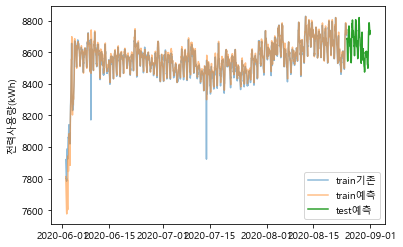

In [ ]:
train_dates = train.date_time.unique()[24:]
test_dates = test.date_time.unique()
y_pred_future = forecast_future['num1']
predict_train = predict_past['num1']

sns.lineplot(x=train_dates, y=train[train.num==1]['전력사용량(kWh)'][24:], alpha=0.5, label='train기존')
sns.lineplot(x=train_dates, y=predict_train, alpha=0.5, label='train예측')
sns.lineplot(x=test_dates, y=y_pred_future, label='test예측')

train 범위에서 기존의 데이터와 예측값이 대체로 겹치는 것으로 보아 학습이 제대로 된 것을 알 수 있고, test 범위에서도 train 데이터와 매끄럽게 이어지는 것을 확인할 수 있습니다.

In [ ]:
submission['answer'] = pd.DataFrame(forecast_future).T.values.reshape(-1)

In [ ]:
# submission.to_csv('./submission/0611_LSTM(smape).csv', index=False)